In [2]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [5]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")


In [6]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")
reddit_results.rename(columns={"date": "date_hour"}, inplace=True)
reddit_results.set_index("date_hour", inplace=True)

reddit_results

,total_sentiment,average_sentiment
date_hour,,
2021-01-01 00:00:00,0.2966,0.015611
2021-01-01 01:00:00,1.6673,0.049038
2021-01-01 02:00:00,0.4588,0.021848
2021-01-01 03:00:00,-0.4329,-0.020614
2021-01-01 04:00:00,0.0000,0.000000
...,...,...
2024-12-31 19:00:00,0.0000,0.000000
2024-12-31 20:00:00,0.0000,0.000000
2024-12-31 21:00:00,0.0000,0.000000


In [7]:
xgb_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.xgb_result.parquet")
xgb_results.set_index('date_hour', inplace=True)
xgb_results = xgb_results.drop("index", axis=1)

xgb_results

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,...,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election,signal
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,0.033333,-0.032500,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,-0.001111,-0.015000,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,0.043333,0.021458,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,0.027500,0.045833,...,0,0,0,0,0,0,0,0,0,-1
2024-01-01 05:00:00,-0.700000,0.0,0.300000,0.0,0.200000,1.0,-0.040000,0.040000,-0.008333,0.015000,...,0,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1
2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1
2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1


In [8]:
rfr_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.rfr_result.parquet")
rfr_results

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election,signal
23498,2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,0.033333,...,0,0,0,0,0,0,0,0,0,NaN
23499,2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,-0.001111,...,0,0,0,0,0,0,0,0,0,NaN
23500,2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,0.043333,...,0,0,0,0,0,0,0,0,0,NaN
23501,2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,0.027500,...,0,0,0,0,0,0,0,0,0,NaN
23502,2024-01-01 05:00:00,-0.700000,0.0,0.300000,0.0,0.200000,1.0,-0.040000,0.040000,-0.008333,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,NaN
32088,2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,NaN
32089,2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,NaN
32090,2024-12-31 22:00:00,0.000000,0.0,0.000000,0.0,0.000000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,NaN


In [9]:
target_col = "target"

start_date = pd.to_datetime("2024-01-01 10:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,43.413306,227.310707,221.324993,221.660881,42681.044834,42415.6,42150.155166,42728.346865,42477.95,42227.553135
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,49.691448,224.266320,220.230351,220.915125,42655.006329,42402.2,42149.393671,42704.546857,42465.50,42226.453143
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,51.804047,205.656846,211.213897,214.871547,42645.307524,42398.1,42150.892476,42702.192013,42463.70,42225.207987
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,54.366986,189.277296,202.627190,208.972902,42667.255486,42426.9,42186.544514,42709.519104,42469.05,42228.580896
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,57.319131,181.380540,197.725248,205.402764,42705.425580,42464.6,42223.774420,42728.955773,42478.00,42227.044227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006


In [10]:
price_indicator_2024.index = pd.to_datetime(price_indicator_2024.index)
xgb_results.index = pd.to_datetime(xgb_results.index)
reddit_results.index = pd.to_datetime(reddit_results.index)

# Merge the DataFrames on the index (date_hour)
merged_df = pd.concat([price_indicator_2024, xgb_results, reddit_results], axis=1)

# Drop any rows with missing values (optional, if needed)
merged_df.dropna(inplace=True)

# Verify the merged DataFrame
merged_df.drop("target",axis=1)
merged_df

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election,signal,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0000,0.000000
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0000,0.000000
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,0.000000
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.6800,0.170000
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0000,0.000000
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0000,0.000000
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0000,0.000000


In [11]:
btc_ner = pd.read_parquet("/workspaces/fyp/crypto_news/data/7a.News_by_hour_filled_return_ner.parquet")
btc_ner.set_index("date_hour", inplace=True)
merged_df = pd.merge(merged_df, btc_ner, on='date_hour', how='inner')
merged_df


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs_y,FTX collapse_y,Uptober_y,U.S. presidential election_y,Spot Bitcoin ETF approval_y,The Merge_y,US election_y,approval of spot Bitcoin ETFs_y,Bitcoin 2024 conference_y,U.S. election_y
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,0,0,0,0,1,0,0,0,0,0
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0,0,0,0,0,0,0,0,0,0


# Statistical Feature Selection

In [12]:
train_start_date = pd.to_datetime("2024-01-01 00:00:00")
train_end_date = pd.to_datetime("2024-11-30 23:00:00")

test_start_date = pd.to_datetime("2024-12-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs_y,FTX collapse_y,Uptober_y,U.S. presidential election_y,Spot Bitcoin ETF approval_y,The Merge_y,US election_y,approval of spot Bitcoin ETFs_y,Bitcoin 2024 conference_y,U.S. election_y
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-12-01 00:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0,0,0,0,0,0,0,0,0,0
2024-12-01 01:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0,0,0,0,0,0,0,0,0,0
2024-12-01 03:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0,0,0,0,0,0,0,0,0,0
2024-12-01 04:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0,0,0,0,0,0,0,0,0,0
2024-12-01 05:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0,0,0,0,0,0,0,0,0,0


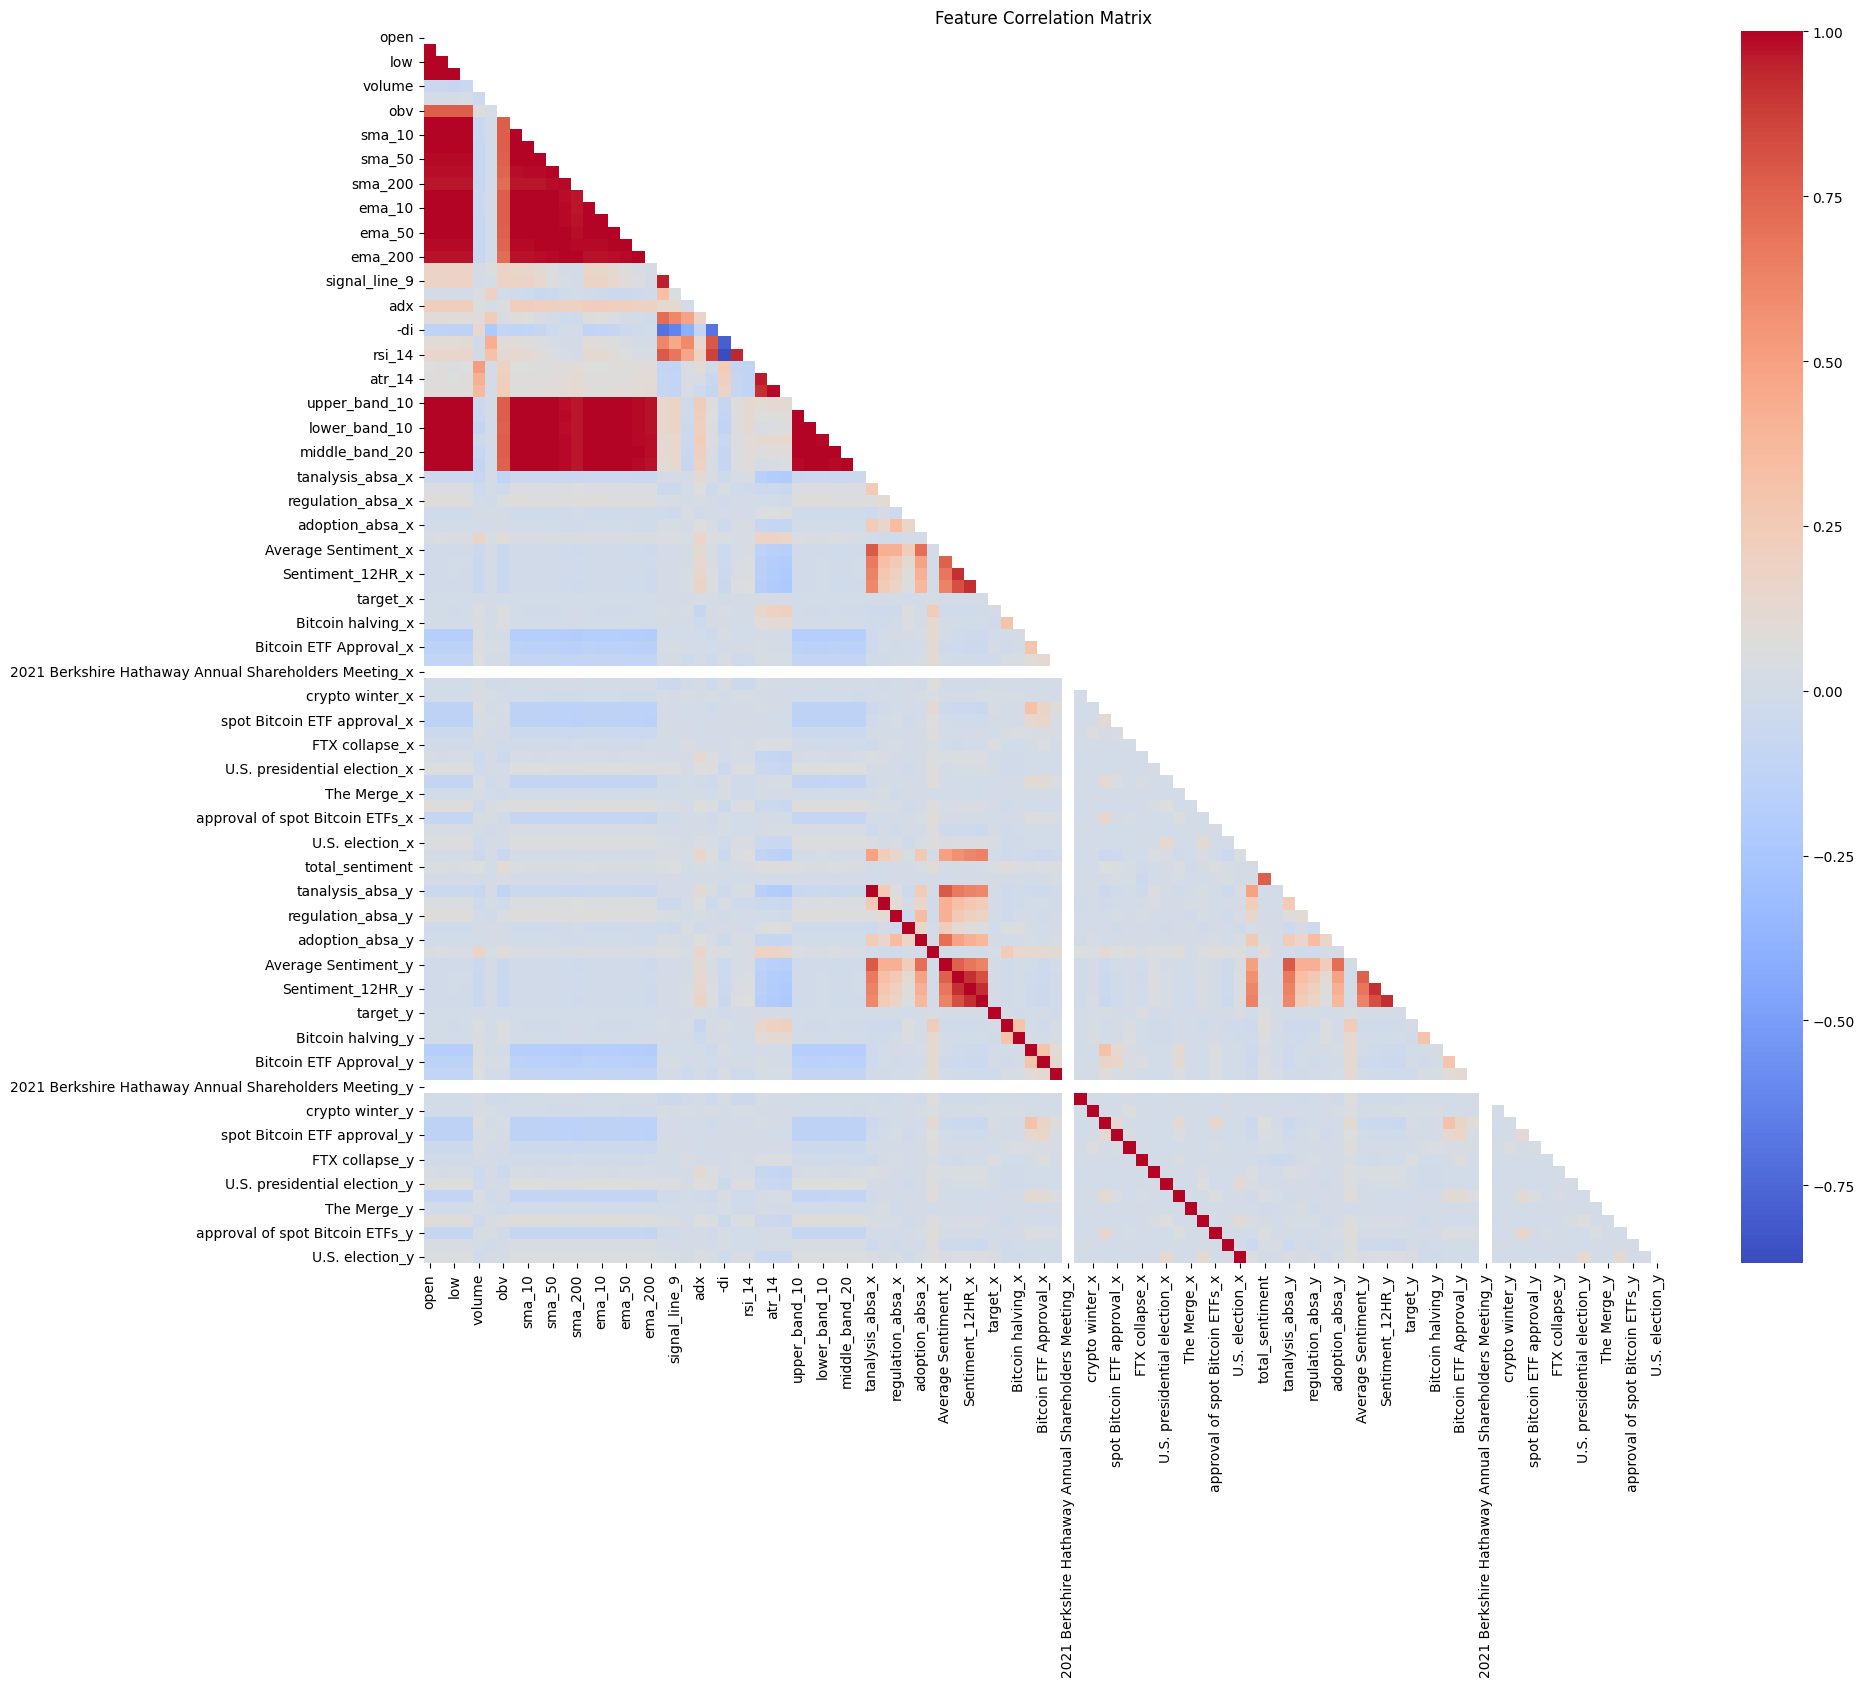

In [13]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [14]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 101 to 44
Top features selected: ['adx', '-di', 'entries_per_hour_x', 'target_x', 'Bitcoin ETF_x', 'Spot Bitcoin ETF Approval_x', 'FTX collapse_x', 'U.S. election_x', 'total_sentiment', 'entries_per_hour_y', 'target_y', 'Bitcoin ETF_y', 'Spot Bitcoin ETF Approval_y', 'FTX collapse_y', 'U.S. election_y']


Index(['adx', '-di', 'entries_per_hour_x', 'target_x', 'Bitcoin ETF_x',
       'Spot Bitcoin ETF Approval_x', 'FTX collapse_x', 'U.S. election_x',
       'total_sentiment', 'entries_per_hour_y', 'target_y', 'Bitcoin ETF_y',
       'Spot Bitcoin ETF Approval_y', 'FTX collapse_y', 'U.S. election_y'],
      dtype='object')

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[selected_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (8536, 12, 15)
y shape: (8536, 1)
Total sequences: 8536
Training sequences: 7682
Testing sequences: 854


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100


2025-04-11 08:06:05.699322: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0298 - val_loss: 0.0017
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 11/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 12/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

array([[-2.29441863e-03],
       [-1.29792141e-02],
       [ 4.92264424e-03],
       [-2.66005960e-03],
       [-5.83798485e-03],
       [ 9.12011135e-04],
       [-3.48588638e-03],
       [ 4.03187051e-03],
       [-7.52260769e-03],
       [ 6.17711246e-03],
       [-8.17107689e-03],
       [ 7.52080092e-03],
       [ 7.96715170e-03],
       [-1.24228769e-03],
       [-2.67472442e-05],
       [-1.41996203e-03],
       [ 2.27164803e-03],
       [-1.32185663e-03],
       [-5.44537371e-03],
       [-4.53165406e-03],
       [ 3.09169455e-03],
       [-7.18005514e-03],
       [ 3.30635067e-03],
       [ 4.95320128e-04],
       [ 2.46991450e-03],
       [ 7.56076723e-03],
       [-2.36421288e-03],
       [ 8.45943205e-03],
       [-3.61528806e-03],
       [-9.55005176e-03],
       [-5.21162990e-04],
       [-2.60854699e-03],
       [ 4.44688136e-03],
       [ 1.69659546e-03],
       [ 1.65059697e-03],
       [ 4.16334311e-04],
       [ 4.27332195e-03],
       [ 1.77567604e-03],
       [-2.7

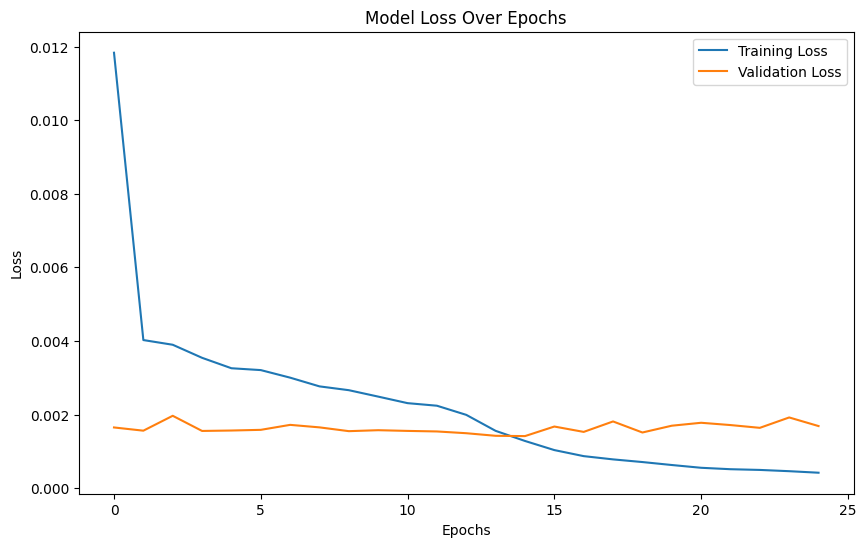

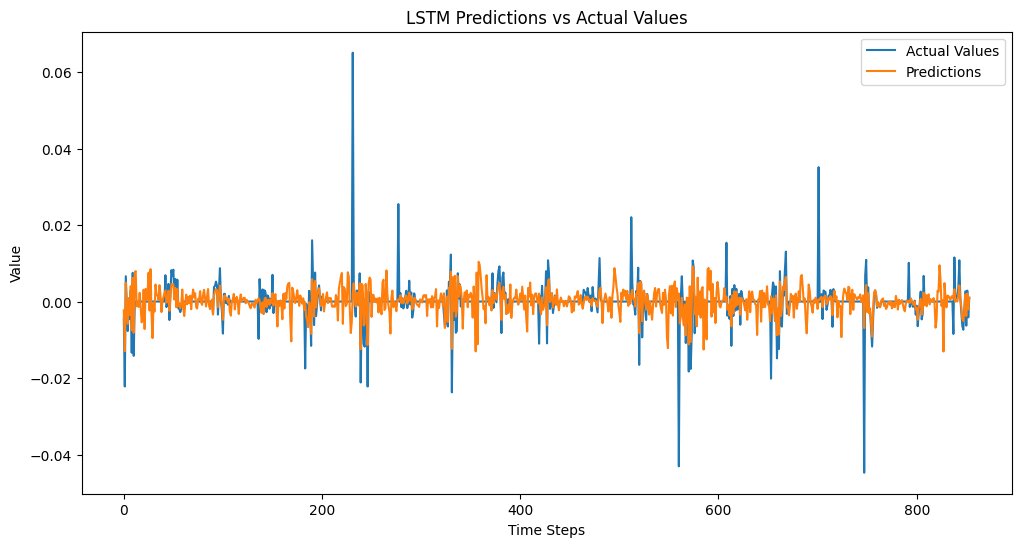

In [17]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)


In [19]:
model.save('stat_features_selection_lstm_model_M1.keras')  # HDF5 format


In [20]:
y_test

array([[0.32954894],
       [0.18437009],
       [0.42011124],
       [0.36073643],
       [0.30295387],
       [0.35691313],
       [0.32844425],
       [0.389597  ],
       [0.25654981],
       [0.42738516],
       [0.24991248],
       [0.35784262],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.42223639],
       [0.35422034],
       [0.36199136],
       [0.40366289],
       [0.32653853],
       [0.376

In [21]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model_M1.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Actual,Predicted
2024-11-25 13:00:00,-0.004460,-0.002294
2024-11-25 14:00:00,-0.022214,-0.012979
2024-11-25 15:00:00,0.006615,0.004923
2024-11-25 16:00:00,-0.000646,-0.002660
2024-11-25 17:00:00,-0.007712,-0.005838
...,...,...
2024-12-31 19:00:00,0.002666,0.001808
2024-12-31 20:00:00,-0.006308,-0.003784
2024-12-31 21:00:00,0.002858,0.002088
2024-12-31 22:00:00,-0.004142,-0.002083


In [22]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: -1 if x > 0.0001 else (1 if x < 0.0001 else 0))
stat_signal_result_df

,Predicted,signal
2024-11-25 13:00:00,-0.002294,1
2024-11-25 14:00:00,-0.012979,1
2024-11-25 15:00:00,0.004923,-1
2024-11-25 16:00:00,-0.002660,1
2024-11-25 17:00:00,-0.005838,1
...,...,...
2024-12-31 19:00:00,0.001808,-1
2024-12-31 20:00:00,-0.003784,1
2024-12-31 21:00:00,0.002088,-1
2024-12-31 22:00:00,-0.002083,1


Overall Annual Return: 384.06%
Overall Annual Sharpe Ratio: 3.1537
Maximum Drawdown: -11.15 %
Alpha: 4.7183
Beta: -0.1773

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       3.840566      0.5475    -0.177253      1.743843       3.153664


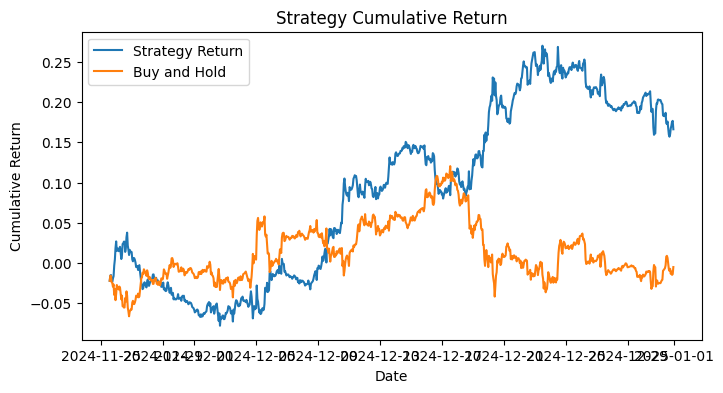

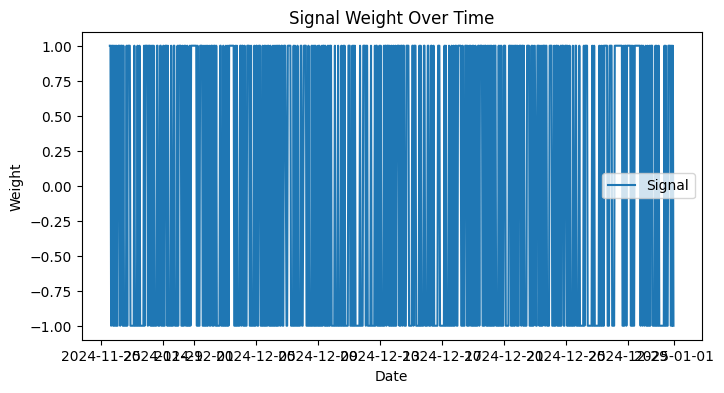

In [23]:
run_backtest(stat_signal_result_df)

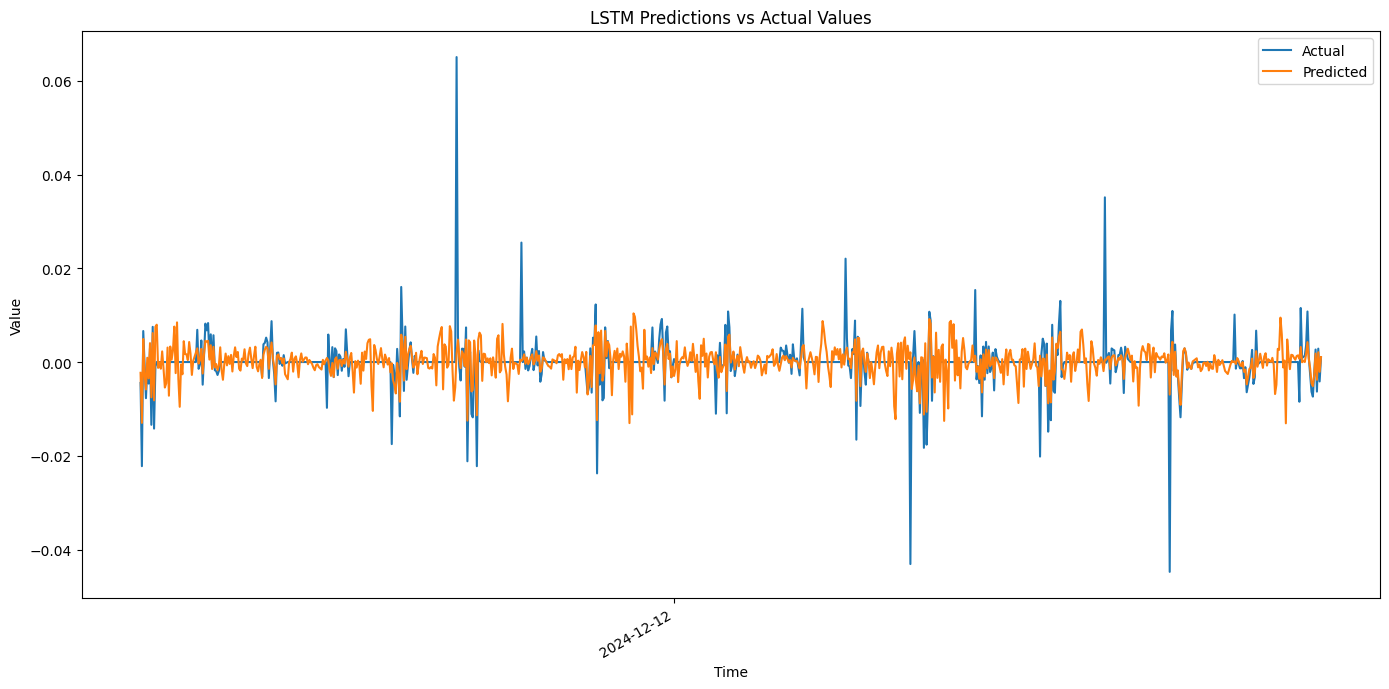

In [24]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [25]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[lstm_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (8536, 12, 15)
y shape: (8536, 1)
Total sequences: 8536
Training sequences: 7682
Testing sequences: 854


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0131 - val_loss: 0.0017
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 9/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/100
193/193 ━━━━━━━━━━━━━━━━━━━━

array([[-1.07727095e-03],
       [-8.57266411e-03],
       [ 1.71256613e-03],
       [-1.92713749e-03],
       [-6.23818766e-03],
       [-2.55581690e-03],
       [-4.03311243e-03],
       [ 7.40383170e-04],
       [-6.83754263e-03],
       [ 3.00898752e-03],
       [-7.51851453e-03],
       [ 4.31714440e-03],
       [ 7.55638303e-03],
       [-4.40023257e-04],
       [ 7.89599901e-04],
       [ 4.95451328e-04],
       [ 3.48250149e-03],
       [ 1.18881499e-03],
       [-3.57693224e-03],
       [-3.83963156e-03],
       [ 2.31955270e-03],
       [-3.07729747e-03],
       [ 2.04880629e-03],
       [ 1.52884901e-03],
       [ 2.92998343e-03],
       [ 7.85240531e-03],
       [ 1.86742167e-03],
       [ 8.37949105e-03],
       [ 7.01586425e-04],
       [-5.19242371e-03],
       [-1.16230687e-03],
       [-1.67379028e-03],
       [ 3.90147395e-03],
       [ 4.32576379e-03],
       [ 3.72620882e-03],
       [ 3.25130625e-03],
       [ 5.53829735e-03],
       [ 4.96508926e-03],
       [ 1.6

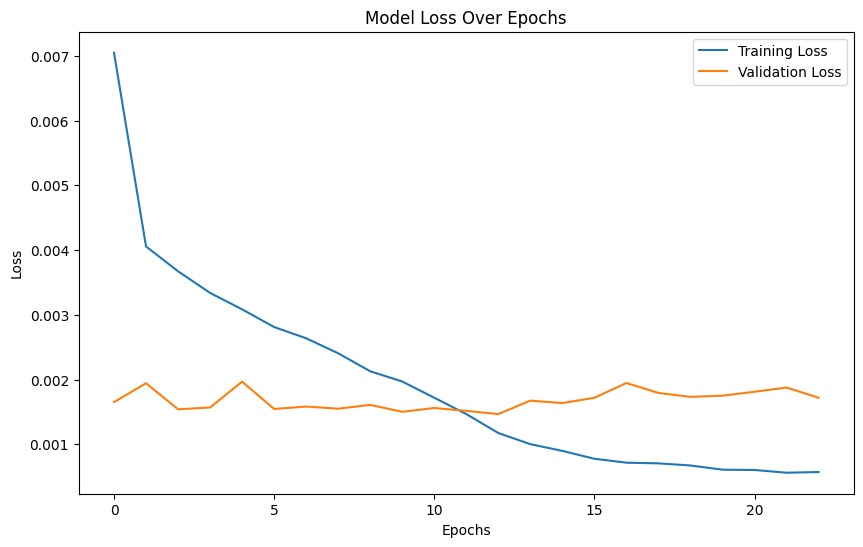

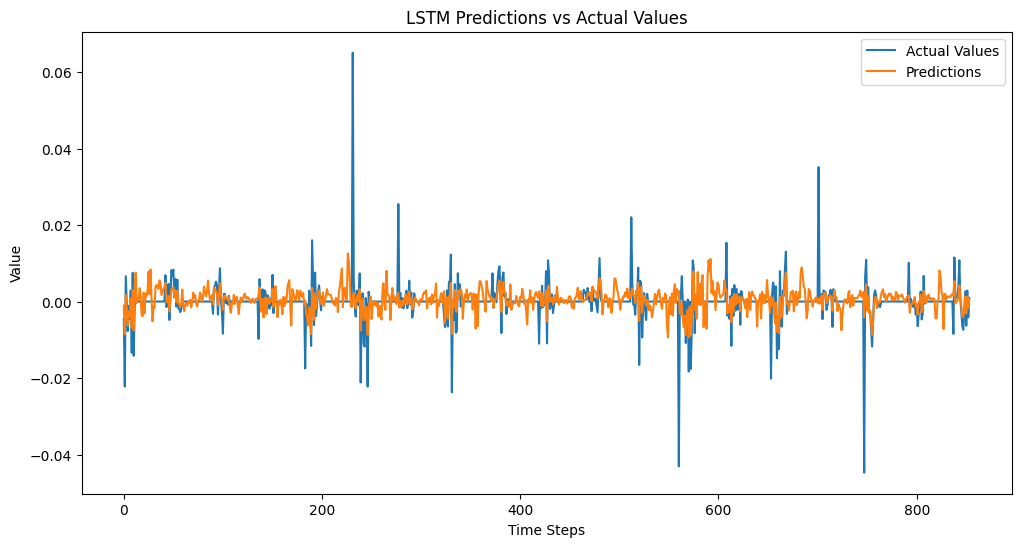

In [28]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

model.save('sequential_selection_lstm_model_M1.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('sequential_selection_lstm_model_M1.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: -1 if x > 0.0001 else (1 if x < -0.0001 else 0))
stat_signal_result_df

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Predicted,signal
2024-11-25 13:00:00,-0.007291,1
2024-11-25 14:00:00,-0.010791,1
2024-11-25 15:00:00,-0.015740,1
2024-11-25 16:00:00,-0.000038,0
2024-11-25 17:00:00,-0.010385,1
...,...,...
2024-12-31 19:00:00,-0.011303,1
2024-12-31 20:00:00,-0.009349,1
2024-12-31 21:00:00,-0.011928,1
2024-12-31 22:00:00,-0.009761,1


Overall Annual Return: -32.59%
Overall Annual Sharpe Ratio: -0.4481
Maximum Drawdown: -17.55 %
Alpha: -0.2737
Beta: 0.7711

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.325866    0.546594     0.771113     -0.319819       -0.44812


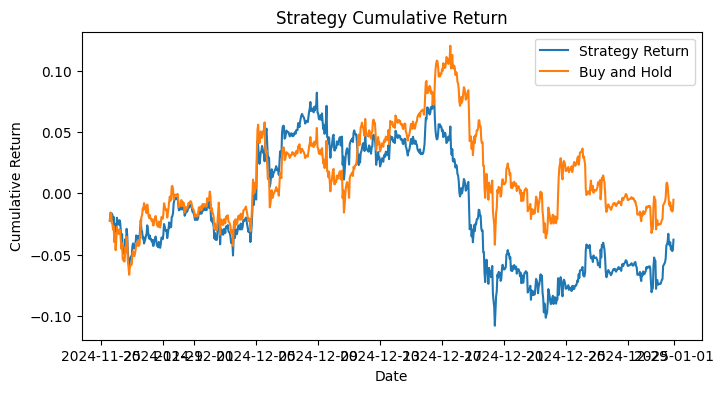

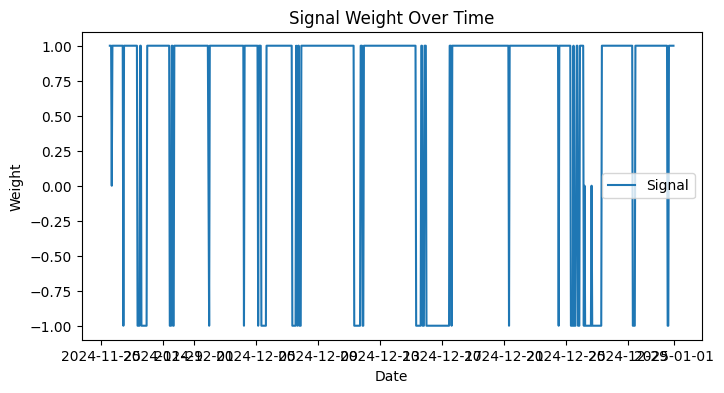

In [31]:
run_backtest(stat_signal_result_df)